# CNN on CIFAR-10 Dataset

### This project is implemented as a part of 'Deep Learning with Tensorflow Project on Udemy by Jose Portilla.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

## Data Operations

In [2]:
# File Path
CIFAR_DIR = 'cifar-10-batches-py/'

In [3]:
# Data Loading

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [4]:
# Directory Setting

dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [5]:
all_data = [0,1,2,3,4,5,6]

In [6]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [7]:
# Setting the BATCHES

batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

## Verification of Data

Verifiying whether the data has been loaded successfully.

In [8]:
X = data_batch1[b"data"]

In [9]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

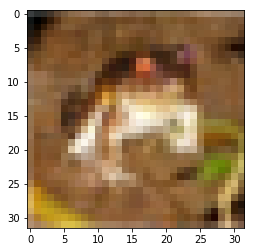

In [10]:
plt.imshow(X[0])

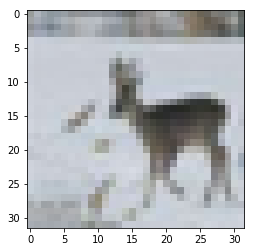

In [11]:
plt.imshow(X[20])

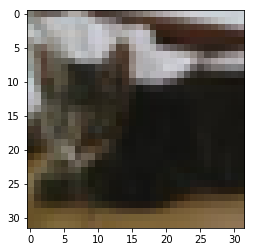

In [12]:
plt.imshow(X[9])

### Helper Functions for Data Handling

In [13]:
# One Hot Encoding

def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [14]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y


---
By using the codes above, we can setup the data and we can use the _next_batch()_ function to pick up batches during the TF Session.

In [15]:
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Tensorflow Model

In [16]:
# Placeholder Creation

x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [17]:
# Dropout Probability

hold_prob = tf.placeholder(tf.float32)

### Helper Functions for CNN

In [18]:
# Weight Initializer
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

# Bias Initializer
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

# 2D Convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# 2D Pooling
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

# Convolutional Layer (RELU Activation)
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

# 'Normal' Neural Network
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Creating Layers for the CNN

**As we have 3 color channels & 32*32 pixel size, we use the following shape of the convolution - [4, 4, 3, 32]**

In [19]:
# Layer 1
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [20]:
# Layer 2
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

---
Flattening the layer by reshaping to [-1, 8x8x64]

In [21]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

**Creating a full layer for a regular NN with size 1024**

In [22]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

**Dropout Layer**

In [23]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

**Final Output**

In [24]:
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function

** Creating a cross-entropy loss function **

In [25]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

### Adam Optimizer

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

## Tensorflow Session

In [27]:
init = tf.global_variables_initializer()

In [28]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1007


Currently on step 100
Accuracy is:
0.4271


Currently on step 200
Accuracy is:
0.476


Currently on step 300
Accuracy is:
0.5195


Currently on step 400
Accuracy is:
0.5323


Currently on step 500
Accuracy is:
0.5562


Currently on step 600
Accuracy is:
0.5652


Currently on step 700
Accuracy is:
0.5677


Currently on step 800
Accuracy is:
0.5895


Currently on step 900
Accuracy is:
0.6021


Currently on step 1000
Accuracy is:
0.5987


Currently on step 1100
Accuracy is:
0.6245


Currently on step 1200
Accuracy is:
0.627


Currently on step 1300
Accuracy is:
0.628


Currently on step 1400
Accuracy is:
0.6364


Currently on step 1500
Accuracy is:
0.6301


Currently on step 1600
Accuracy is:
0.6583


Currently on step 1700
Accuracy is:
0.6624


Currently on step 1800
Accuracy is:
0.668


Currently on step 1900
Accuracy is:
0.6614


Currently on step 2000
Accuracy is:
0.6587


Currently on step 2100
Accuracy is:
0.6657


Currently on step 2200
Acc

### Thus, CNN gives us around 70% of accuracy on the CIFAR-10 dataset, which is pretty good. We can improve this accuracy by changing the filter size, learning rate and other factors.